In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import joblib  # For saving the ML model
import os

# Load the data
train_data = pd.read_csv('train.csv')
dev_data = pd.read_csv('dev.csv')

# Combine claim and evidence into a single text entry
train_data['text'] = train_data['Claim'] + " " + train_data['Evidence']
dev_data['text'] = dev_data['Claim'] + " " + dev_data['Evidence']


[nltk_data] Downloading package stopwords to /Users/daim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Preprocess text data for ML model: TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['text'])
X_dev_tfidf = tfidf_vectorizer.transform(dev_data['text'])

In [28]:
# Preprocess text data for DL model: Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(train_data['text'])
X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_dev_seq = tokenizer.texts_to_sequences(dev_data['text'])
max_length = max(max(len(x) for x in X_train_seq), max(len(x) for x in X_dev_seq))
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_dev_padded = pad_sequences(X_dev_seq, maxlen=max_length, padding='post')

In [29]:
# Labels
y_train = train_data['label']
y_dev = dev_data['label']

In [ ]:
# Machine Learning Model: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

In [24]:
# This code is used to evaluate the model
y_dev_pred_lr = lr_model.predict(X_dev_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_dev, y_dev_pred_lr))
print(classification_report(y_dev, y_dev_pred_lr))


Logistic Regression Accuracy: 0.8076274046574418
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4327
           1       0.71      0.48      0.57      1599

    accuracy                           0.81      5926
   macro avg       0.77      0.71      0.73      5926
weighted avg       0.80      0.81      0.79      5926



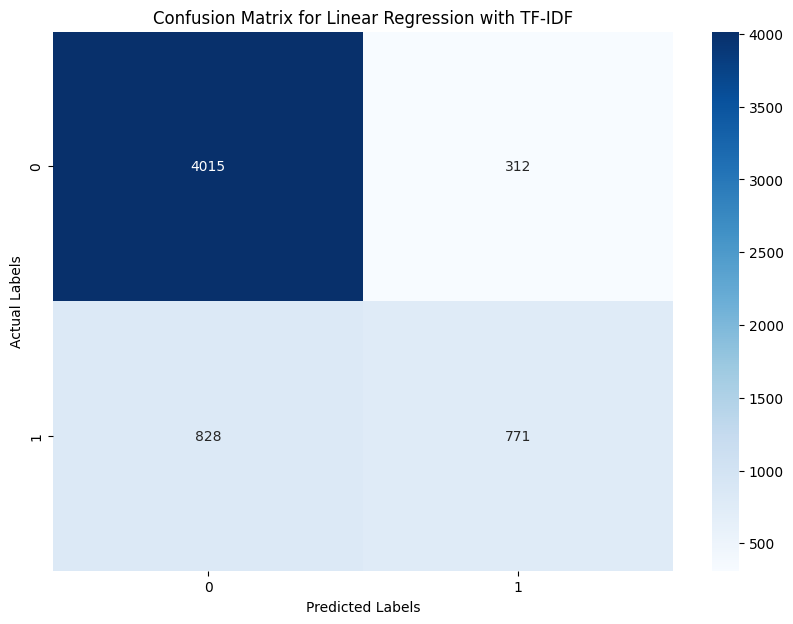

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_dev, y_dev_pred_lr)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Linear Regression with TF-IDF')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


In [38]:
# Save the predictions to a CSV file
predictions_df_lr= pd.DataFrame(y_dev_pred_lr, columns=['prediction'])
try:
    predictions_df_lr.to_csv('lr_predictions_training.csv', index=False)
    print(f"Predictions saved successfully to lr_predictions_training.csv")
except Exception as e:
    print(f"Error saving the predictions: {e}")

Predictions saved successfully to lr_predictions_training.csv


In [8]:
# Save the Logistic Regression model
joblib.dump(lr_model, 'lr_model.joblib')

['lr_model.joblib']

In [34]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [33]:
import pickle
with open('lr_model.pkl', 'wb') as file:  # 'wb' means "write binary"
    pickle.dump(lr_model, file)

In [30]:
# Model building with bidirectional LSTM and GloVe embeddings
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_dev_padded, y_dev))


Epoch 1/10
371/371 [==============================] - 1049s 3s/step - loss: 0.5403 - accuracy: 0.7462 - val_loss: 0.5184 - val_accuracy: 0.7543
Epoch 2/10
371/371 [==============================] - 1012s 3s/step - loss: 0.4922 - accuracy: 0.7667 - val_loss: 0.4722 - val_accuracy: 0.7751
Epoch 3/10
371/371 [==============================] - 1049s 3s/step - loss: 0.4821 - accuracy: 0.7721 - val_loss: 0.4594 - val_accuracy: 0.7911
Epoch 4/10
371/371 [==============================] - 1111s 3s/step - loss: 0.4768 - accuracy: 0.7755 - val_loss: 0.4628 - val_accuracy: 0.7854
Epoch 5/10
371/371 [==============================] - 1042s 3s/step - loss: 0.4688 - accuracy: 0.7773 - val_loss: 0.4524 - val_accuracy: 0.7872
Epoch 6/10
371/371 [==============================] - 1107s 3s/step - loss: 0.4644 - accuracy: 0.7802 - val_loss: 0.4612 - val_accuracy: 0.7877
Epoch 7/10
371/371 [==============================] - 1134s 3s/step - loss: 0.4599 - accuracy: 0.7812 - val_loss: 0.4580 - val_accuracy:

In [31]:
# This code is used to evaluate the DL model
y_dev_pred_dl = (model.predict(X_dev_padded) > 0.5).astype(int)
print("LSTM Model Accuracy:", accuracy_score(y_dev, y_dev_pred_dl))
print(classification_report(y_dev, y_dev_pred_dl))



186/186 [==============================] - 40s 205ms/step
LSTM Model Accuracy: 0.7975025312183598
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4327
           1       0.71      0.42      0.53      1599

    accuracy                           0.80      5926
   macro avg       0.76      0.68      0.70      5926
weighted avg       0.79      0.80      0.78      5926



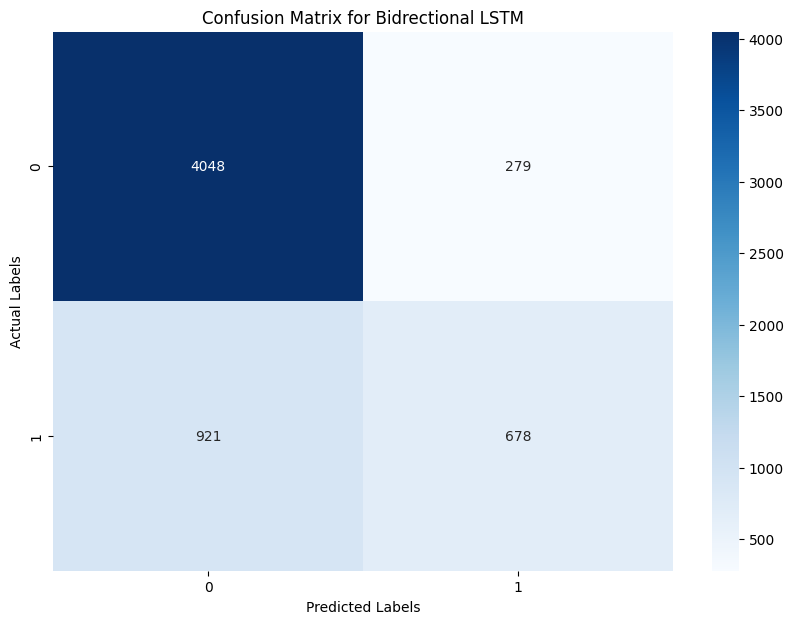

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_dev, y_dev_pred_dl)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Bidrectional LSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


In [37]:
# Save the predictions to a CSV file
predictions_df_lstm = pd.DataFrame(y_dev_pred_dl, columns=['prediction'])
try:
    predictions_df_lstm.to_csv('lstm_predictions_training.csv', index=False)
    print(f"Predictions saved successfully to lstm_predictions_training.csv")
except Exception as e:
    print(f"Error saving the predictions: {e}")

Predictions saved successfully to lstm_predictions_training.csv


In [42]:
# Save the LSTM model
model.save('lstm_model.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
joblib.dump(tokenizer, 'lstm_tokenizer.pkl')

['lstm_tokenizer.pkl']